In [66]:
#Importing packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import random
from astropy.io import ascii
from scipy.stats import norm, gamma
import arviz
import seaborn as sns

In [29]:
df = pd.read_csv("BD+28 4211.csv")
print(df.head())

                objID  filterID       obsTime          ra        dec  airMass  \
0  142623277801099039         3  55783.533723  327.780210  28.856972  1.10768   
1  142623277801099039         3  55783.545668  327.780254  28.856969  1.14538   
2  142623277801099039         3  56145.539254  327.780176  28.856968  1.09852   
3  142623277801099039         3  56145.550525  327.780095  28.857105  1.13188   
4  142623277801099039         3  55407.562255  327.780157  28.856985  1.10530   

    psfFlux  psfFluxErr  infoFlag2  
0  0.000012    0.000001         32  
1  0.000011    0.000001         32  
2  0.000016    0.000002          0  
3  0.000010    0.000002         32  
4  0.000015    0.000002          0  


In [30]:
#Looking at data summary
flux = df['psfFlux']
time = df['obsTime']
df.describe()

,objID,filterID,obsTime,ra,dec,airMass,psfFlux,psfFluxErr,infoFlag2
count,1.400000e+01,14.0,14.000000,14.000000,14.000000,14.000000,14.000000,1.400000e+01,14.000000
mean,1.426233e+17,3.0,55837.482702,327.780167,28.856981,1.127111,0.000013,1.637749e-06,9.142857
std,1.660398e+01,0.0,387.244694,0.000042,0.000048,0.051441,0.000003,4.457238e-07,15.001831
min,1.426233e+17,3.0,55407.562255,327.780095,28.856902,1.052890,0.000009,1.042840e-06,0.000000
25%,1.426233e+17,3.0,55496.573130,327.780144,28.856963,1.100215,0.000012,1.349368e-06,0.000000
50%,1.426233e+17,3.0,55783.539695,327.780171,28.856973,1.113085,0.000012,1.628565e-06,0.000000
75%,1.426233e+17,3.0,56061.476757,327.780188,28.856981,1.146265,0.000016,1.796310e-06,24.000000
max,1.426233e+17,3.0,56545.307819,327.780254,28.857105,1.254100,0.000017,2.549600e-06,32.000000


Text(0.5, 1.0, 'Observed Flux over Time')

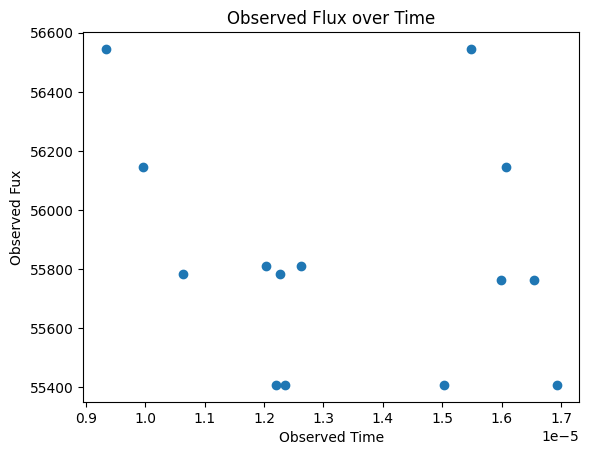

In [31]:
#Plotting flux over time
plt.scatter(flux,time)
plt.xlabel("Observed Time")
plt.ylabel("Observed Fux")
plt.title("Observed Flux over Time")

Text(0.5, 1.0, 'Good Measurements')

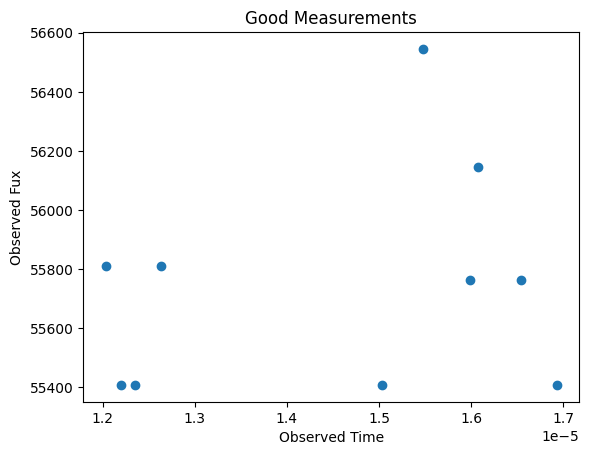

In [32]:
#Plotting Good flags vs problematic flags

#Define "Good" and "Problematic"
good_measurement = df[df['infoFlag2']==0]
problematic_measurement = df[df['infoFlag2']==32] 

plt.scatter(good_measurement['psfFlux'],good_measurement['obsTime'])
plt.xlabel("Observed Time")
plt.ylabel("Observed Fux")
plt.title("Good Measurements")


Text(0.5, 1.0, 'Problematic Measurements')

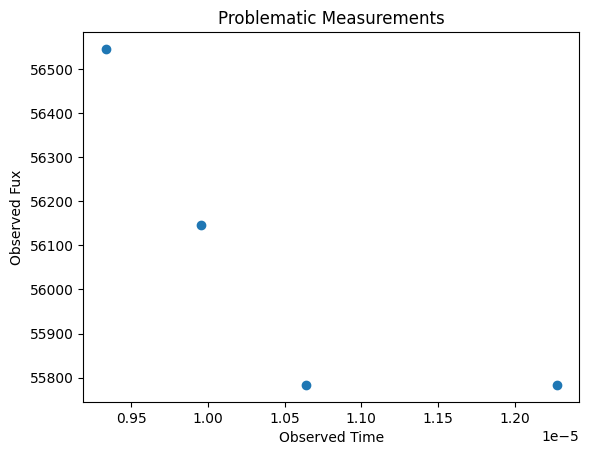

In [33]:
plt.scatter(problematic_measurement['psfFlux'],problematic_measurement['obsTime'])
plt.xlabel("Observed Time")
plt.ylabel("Observed Fux")
plt.title("Problematic Measurements")

array([[<Axes: title={'center': 'psfFlux'}>]], dtype=object)

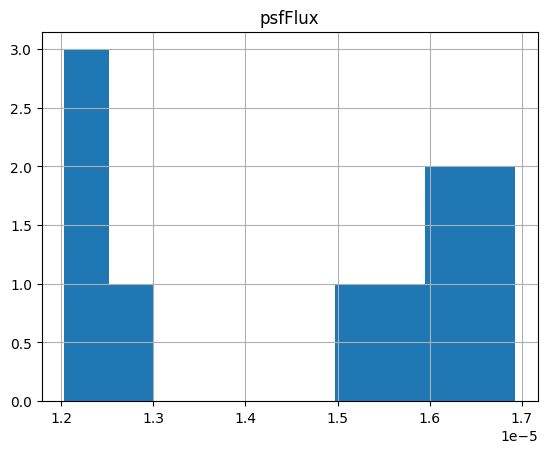

In [34]:
#histograms
good_measurement.hist('psfFlux')

array([[<Axes: title={'center': 'psfFlux'}>]], dtype=object)

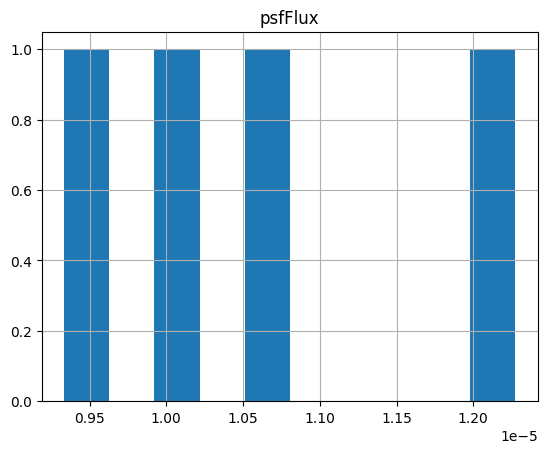

In [35]:
problematic_measurement.hist('psfFlux')

Now we build the model. Assume that all the flux measurements 𝑥𝑖 are indipendent and
identically distributed, i.e., 𝑋𝑖 ∼ 𝑁 (𝜇, 1/𝜆). Where 𝜆 = 1/𝜎2 is the precision.
Consider the following priors for the parameters 𝜇 and 𝜆:
𝜇 ∼ 𝑁 (𝑎, 𝑏)
𝜆 ∼ Gamma(𝑐, 𝑑)

In [57]:
from scipy.stats import norm, gamma

y = good_measurement['psfFlux']
n = len(y)
ybar = np.mean(y)
sv_y = np.var(y)


a = 2
b = 2
c = 1.01
d = 0.1



In [64]:
#Minimum Sample Size Needed

from scipy.stats import chi2
from scipy.special import gamma

def mESS(p,alpha=0.05,epsilon=0.05):
    X2=chi2.ppf(1-alpha, p)
    min_num=np.rint(np.pi*(2./p/gamma(p/2))**(2/p)*X2/epsilon**2)
    return min_num.astype(int)
print('Minimum Monte Carlo sample size',mESS(2))

Minimum Monte Carlo sample size 7529


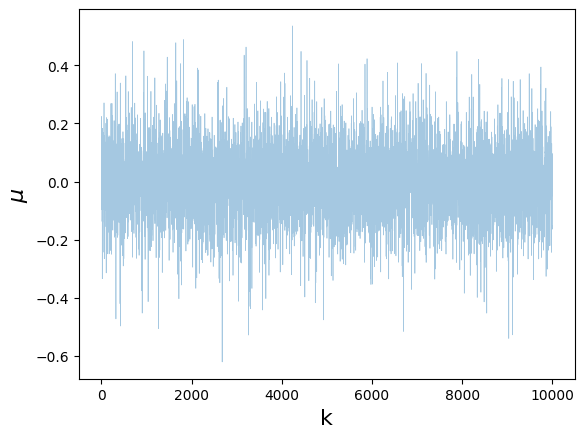

In [67]:
msim = 10000

markov = np.zeros((msim,2))

markov[0,0]=ybar
markov[0,1]=sv_y

sim_range = range(1,msim)

for i in sim_range:
    markov[i,0] = norm.rvs(loc = ybar, scale = np.sqrt(markov[i-1,1]/n), size =1)[0]
    markov[i,1] = gamma.rvs(a=c, scale = d, loc = sv_y, size = 1)[0]

x = np.arange(0,msim, step = 1)
plt.plot(x[2:], markov[2:,0],lw=0.5, alpha=0.4)
plt.ylabel(r'$\mu$', fontsize = 16)
plt.xlabel('k', fontsize = 16)
plt.show()

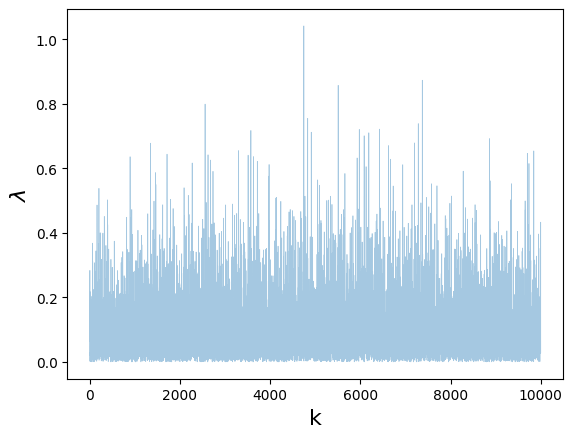

In [68]:
plt.plot(x[1:], markov[1:,1],lw=0.5, alpha=0.4)
plt.ylabel(r'$\lambda$', fontsize = 16)
plt.xlabel('k', fontsize = 16)
plt.show()


<Figure size 640x480 with 0 Axes>

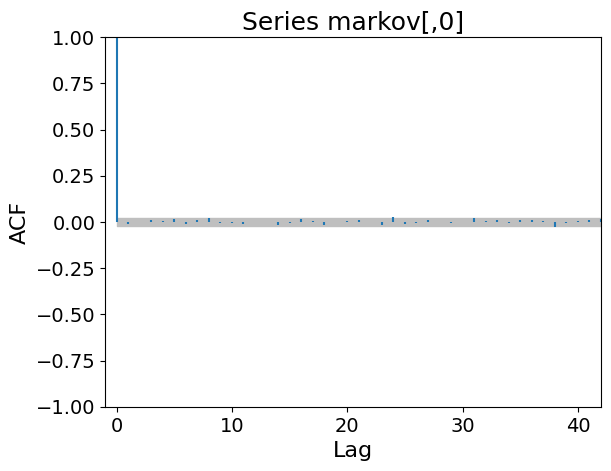

In [69]:
plt.clf() # ~~~~~~~ ACF Markov 0
arviz.plot_autocorr(markov[:,0])
plt.xlim(-1,42)

plt.title('Series markov[,0]', fontsize = 18)
plt.ylabel('ACF', fontsize = 16)
plt.xlabel('Lag', fontsize = 16)
plt.show()



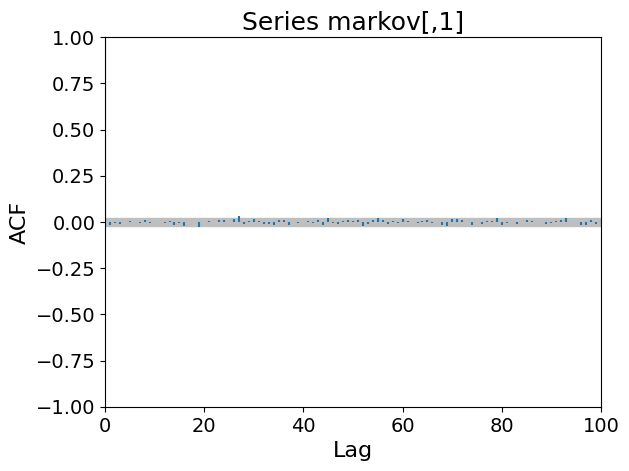

In [70]:
#

arviz.plot_autocorr(markov[:,1])
plt.title('Series markov[,1]', fontsize = 18)
plt.ylabel('ACF', fontsize = 16)
plt.xlabel('Lag', fontsize = 16)
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


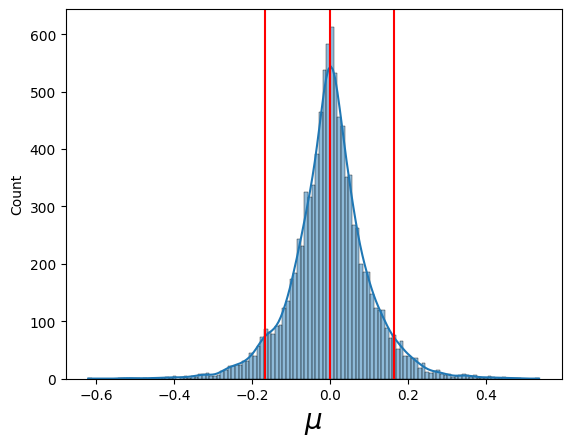

In [71]:
sns.histplot(markov[:,0], kde=True)
m_0_mean = np.mean(markov[:,0])
m_0_low = np.percentile(markov[:,0], 5)
m_0_up= np.percentile(markov[:,0], 95)
plt.axvline(m_0_mean, color = 'r')
plt.axvline(m_0_low, color = 'r')
plt.axvline(m_0_up, color = 'r')
plt.xlabel(r'$\mu$',fontsize=20)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


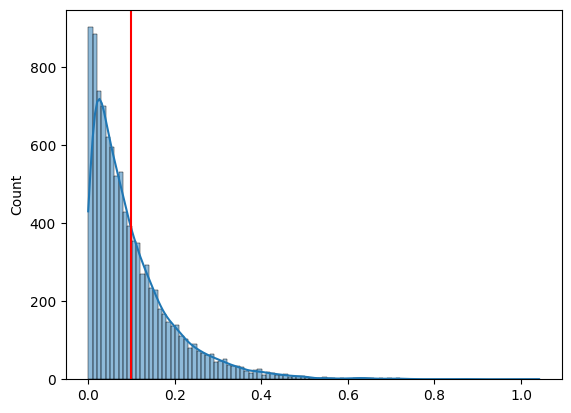

In [72]:
sns.histplot(markov[:,1], kde=True)
m_1_mean = np.mean(markov[:,1])
m_1_low = np.percentile(markov[:,1], 5)
m_1_up= np.percentile(markov[:,1], 95)
plt.axvline(m_1_mean, color = 'r')

/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_93448/2758553896.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  a_post = (n*ybar*b+a/markov[i-1,1])/(n*b+1/markov[i-1,1])
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_93448/2758553896.py:15: RuntimeWarning: invalid value encountered in scalar divide
  a_post = (n*ybar*b+a/markov[i-1,1])/(n*b+1/markov[i-1,1])
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_93448/2758553896.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  b_post = (b/markov[i-1,1])/(b*n+1/markov[i-1,1])
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_93448/2758553896.py:16: RuntimeWarning: invalid value encountered in scalar divide
  b_post = (b/markov[i-1,1])/(b*n+1/markov[i-1,1])


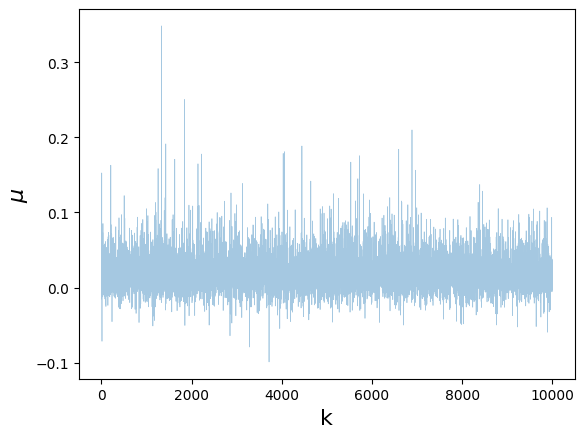

In [73]:
#ignore this part

a = 1
b = 1
c = 1
d = 1

msim = 10000

markov = np.zeros((msim,2))

markov[0,0]=ybar
markov[0,1]=sv_y

a_post = (n*ybar*b+a/markov[i-1,1])/(n*b+1/markov[i-1,1])
b_post = (b/markov[i-1,1])/(b*n+1/markov[i-1,1])
c_post = c+n/2
d_post = d+((n*(markov[i-1,0]-ybar)**2)/2)


sim_range = range(1,msim)

for i in sim_range:
    markov[i,0] = norm.rvs(loc = (n*ybar*b+a/markov[i-1,1])/(n*b+1/markov[i-1,1]), scale = (b/markov[i-1,1])/(b*n+1/markov[i-1,1]), size=1)[0]
    markov[i,1] = gamma.rvs(a=c+n/2, scale = d+((n*(markov[i-1,0]-ybar)**2)/2), size = 1)[0]

x = np.arange(0,msim, step = 1)
plt.plot(x[2:], markov[2:,0],lw=0.5, alpha=0.4)
plt.ylabel(r'$\mu$', fontsize = 16)
plt.xlabel('k', fontsize = 16)
plt.show()

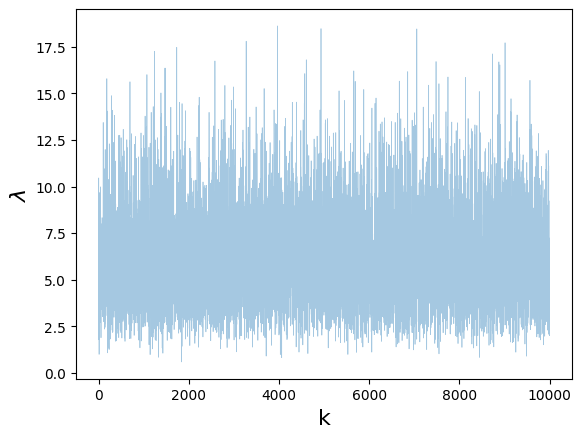

In [74]:
plt.plot(x[1:], markov[1:,1],lw=0.5, alpha=0.4)
plt.ylabel(r'$\lambda$', fontsize = 16)
plt.xlabel('k', fontsize = 16)
plt.show()




Double check when solutions posted:
Parameters for distributions in MC
Number of parameters for minimum number of simulations needed (2 or 4)
If loc for normal distribution is just ybar, wont it always converge to exactly the mean??